In [13]:
from data import get_loader, get_data_path
import torch.nn as nn
from torch.utils import data
import numpy as np
from utils.helpers import colorize_mask
import utils.palette as palette
import PIL
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import os

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

class DeNormalize(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, tensor):
        IMG_MEAN = torch.from_numpy(self.mean.copy())
        IMG_MEAN, _ = torch.broadcast_tensors(IMG_MEAN.unsqueeze(1).unsqueeze(2), tensor)
        tensor = tensor+IMG_MEAN
        tensor = (tensor/255).float()
        tensor = torch.flip(tensor,(0,))
        return tensor

    
restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])

classes = np.array(("road", "sidewalk",
    "building", "wall", "fence", "pole",
    "traffic_light", "traffic_sign", "vegetation",
    "terrain", "sky", "person", "rider",
    "car", "truck", "bus",
    "train", "motorcycle", "bicycle"))


gta_save_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/data_visualization/gta/"
viz_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/data_visualization/"


# GTA

In [2]:
num_classes = 19
data_loader = get_loader('gta_test')
data_path = get_data_path('gta')
test_dataset = data_loader(data_path, list_path = './data/gta5_list/train.txt', img_size=None, mean=IMG_MEAN)
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)
interp = nn.Upsample(size=(720,1280), mode='bilinear', align_corners=True)
ignore_label = 255

In [3]:

# compute all road distributions


road_count_img_list = []

for val in range(19):
    img, label, _, _, _ = test_dataset[0] #28

    road_count_img = np.zeros_like(label)
    road_count_img_list.append(road_count_img)


for i in tqdm(range(0, len(test_dataset))):
    img, label, _, _, _ = test_dataset[i] #28

    if not (label.shape[0] == 1052 and label.shape[1] == 1914):
        continue

    for val in range(19):
        road_count_img = road_count_img_list[val]
        bol_arr = label == val

        road_count_img += bol_arr.astype(np.int32)

    if i > 1000:
        break


  4%|▍         | 1001/24966 [02:33<1:01:05,  6.54it/s]


In [4]:
class_count = []

for val in range(num_classes):
    class_count.append(np.sum(road_count_img_list[val]))

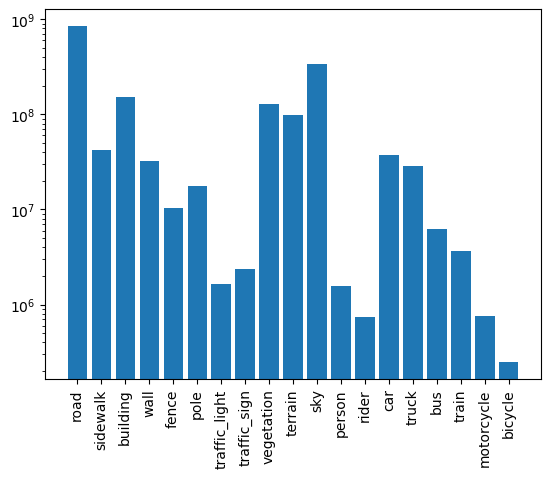

In [5]:
a = plt.bar(x=classes,height=class_count, log=True)
a = plt.xticks(rotation="vertical")
plt.savefig(os.path.join(viz_dir, "gta_distr"))

In [6]:
for val in range(num_classes):
    road_count_img = road_count_img_list[val]
    road_distr = 255 * road_count_img / np.max(road_count_img)
    road_distr = np.repeat(road_distr.reshape((*road_distr.shape, 1)), 3, axis=2)
    road_distr = PIL.Image.fromarray(road_distr.astype(np.uint8))
    road_distr.save(os.path.join(gta_save_dir, "{}.png".format(classes[val])))

# Cityscapes

In [7]:

cs_save_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/data_visualization/cityscapes"

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
input_size = (512,1024)

num_classes = 19
data_loader = get_loader('cityscapes')
data_path = get_data_path('cityscapes')
test_dataset = data_loader( data_path, img_size=input_size, img_mean = IMG_MEAN, is_transform=True, split='train')
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
interp = nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
ignore_label = 250

Found 2975 train images


In [8]:

# compute all road distributions
road_count_img_list = []

for val in range(19):
    img, label, _, _, _ = test_dataset[0] #28

    road_count_img = np.zeros_like(label)
    road_count_img_list.append(road_count_img)


for i in tqdm(range(0, len(test_dataset))):
    img, label, _, _, _ = test_dataset[i] #28

    # if not (label.shape[0] == 1052 and label.shape[1] == 1914):
    #     continue

    for val in range(19):
        road_count_img = road_count_img_list[val]
        bol_arr = label.detach().numpy() == val

        road_count_img += bol_arr.astype(np.int32)

    if i > 1000:
        break


 34%|███▎      | 1001/2975 [02:33<05:01,  6.54it/s]


In [9]:
class_count = []

for val in range(num_classes):
    class_count.append(np.sum(road_count_img_list[val]))

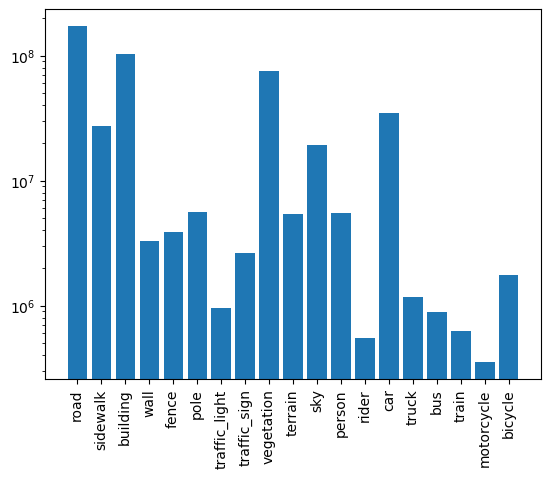

In [10]:
a = plt.bar(x=classes,height=class_count, log=True)
a = plt.xticks(rotation="vertical")
plt.savefig(os.path.join(viz_dir, "cs_distr"))

In [11]:
for val in range(num_classes):
    road_count_img = road_count_img_list[val]
    road_distr = 255 * road_count_img / np.max(road_count_img)
    road_distr = np.repeat(road_distr.reshape((*road_distr.shape, 1)), 3, axis=2)
    road_distr = PIL.Image.fromarray(road_distr.astype(np.uint8))
    road_distr.save(os.path.join(cs_save_dir, "{}.png".format(classes[val])))

# DACS augmentation

In [14]:
from utils import transformmasks
from utils import transformsgpu
from utils.helpers import get_concat_h, get_concat_v
import random
import json

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = transformsgpu.colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = transformsgpu.gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target

input_size = (1024, 512)
num_classes = 19
data_loader = get_loader('gta_test')
data_path = get_data_path('gta')
gta_dataset = data_loader(data_path, list_path = './data/gta5_list/train.txt', img_size=input_size, mean=IMG_MEAN)
testloader = data.DataLoader(gta_dataset, batch_size=1, shuffle=True, pin_memory=True)
interp = nn.Upsample(size=(720,1280), mode='bilinear', align_corners=True)
ignore_label = 255

input_size = (512,1024)
num_classes = 19
data_loader = get_loader('cityscapes')
data_path = get_data_path('cityscapes')
cs_dataset = data_loader( data_path, img_size=input_size, img_mean = IMG_MEAN, is_transform=True, split='train')
testloader = data.DataLoader(cs_dataset, batch_size=1, shuffle=False, pin_memory=True)
interp = nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
ignore_label = 250

Found 2975 train images


In [15]:
classes = np.array(("road", "sidewalk",
    "building", "wall", "fence", "pole",
    "traffic_light", "traffic_sign", "vegetation",
    "terrain", "sky", "person", "rider",
    "car", "truck", "bus",
    "train", "motorcycle", "bicycle"))

things = np.array(("pole",
    "traffic_light", "traffic_sign",
    "person", "rider",
    "car", "truck", "bus",
    "train", "motorcycle", "bicycle"))

d_classes = dict(zip(np.arange(len(classes)), classes))
d_classes[255] = "none"

In [44]:
d_classes

{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic_light',
 7: 'traffic_sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 255: 'none'}

In [51]:
t = [5,6,7]

t.remove(6)

t

[5, 7]

In [52]:
def get_pair_class(c):

    if c in [5,6,7]:
        paired = [5,6,7]
        paired.remove(c)
        return paired
    elif c in [17, 18]:
        return [12]
    elif c == 12:
        return [17, 18]
    else:
        return None
    


In [170]:
save_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/dacs_augmentation/matches"
with_pairs = False
only_things = False
matched = True

with open('cs_to_gta_indx.json') as json_file:
    cs_to_gta_indx = json.load(json_file)
    print(cs_to_gta_indx)

road_count_img_list = []

for val in range(19):
    img, label, _, _, _ = gta_dataset[0] #28

    road_count_img = np.zeros_like(label)
    road_count_img_list.append(road_count_img)

for indx in tqdm(range(0, 100)):
    cs_indx = indx
    if matched:
        gt_indx = cs_to_gta_indx[str(cs_indx)]
    else:
        gt_indx = cs_indx # random indx?

    # load gta image
    img, label, _, _, _ = gta_dataset[gt_indx] #28
    img = torch.tensor(img)
    label = torch.tensor(label)

    # copy only thing classes
    if only_things:
        classes = torch.unique(label)
        classes = torch.tensor([x for x in classes if d_classes[int(x)] in things])
        nclasses = classes.shape[0]
        classes = (classes[torch.Tensor(np.random.choice(nclasses, int((nclasses+nclasses%2)/2),replace=False)).long()])
        print(list(map(lambda x: d_classes[int(x)], classes)))
    else:
        # copy a random set of classes
        classes = torch.unique(label)
        #classes=classes[classes!=ignore_label]
        nclasses = classes.shape[0]
        #if nclasses > 0:
        classes = (classes[torch.Tensor(np.random.choice(nclasses, int((nclasses+nclasses%2)/2),replace=False)).long()])

    # with pairs
    if with_pairs:
        classes_with_pairs = []
        classes_with_pairs.append(classes)
        for c in classes:
            pairs = get_pair_class(c)
            if pairs is not None:
                print('found class ', c, ', added class ', pairs)
                classes_with_pairs.append(torch.tensor(pairs))
        classes_with_pairs = torch.cat(classes_with_pairs)
        classes = torch.unique(classes_with_pairs)
        print(list(map(lambda x: d_classes[int(x)], classes)))


    s = ""
    for k in list(map(lambda x: d_classes[int(x)], classes)):
        if not s:
            s += k
        else:
            s += "+"  + k

    MixMask0 = transformmasks.generate_class_mask(label, classes).unsqueeze(0).cuda()

    random_flip = False
    color_jitter = False
    gaussian_blur = False

    strong_parameters = {"Mix": MixMask0}
    if random_flip:
        strong_parameters["flip"] = random.randint(0, 1)
    else:
        strong_parameters["flip"] = 0
    if color_jitter:
        strong_parameters["ColorJitter"] = random.uniform(0, 1)
    else:
        strong_parameters["ColorJitter"] = 0
    if gaussian_blur:
        strong_parameters["GaussianBlur"] = random.uniform(0, 1)
    else:
        strong_parameters["GaussianBlur"] = 0

    # load cs image
    cs_img, cs_label, _, _, _ = cs_dataset[cs_indx] #28
    cs_label[cs_label == 250] = 255

    # create mixed image
    inputs_u_s0, target = strongTransform(strong_parameters, data = torch.cat((img.unsqueeze(0),cs_img.unsqueeze(0))).cuda(), target=torch.cat((label.unsqueeze(0), cs_label.unsqueeze(0))).cuda())
    inputs_u_s0 = inputs_u_s0.detach().cpu()
    target = target.detach().cpu()

    # restore_transform(inputs_u_s0[0])

    # create visualization

    h_cat1 = get_concat_h(restore_transform(img), restore_transform(cs_img))
    h_cat1 = get_concat_h(h_cat1, restore_transform(inputs_u_s0[0]))

    h_cat2 = get_concat_h(colorize_mask(label.detach().numpy(), palette.CityScpates_palette), colorize_mask(cs_label.detach().numpy(), palette.CityScpates_palette))
    h_cat2 = get_concat_h(h_cat2, colorize_mask(target.numpy()[0,:,:], palette.CityScpates_palette))

    h_cat3 = get_concat_h(PIL.Image.fromarray((255*MixMask0.detach().cpu().numpy()[0,:,:]).astype(np.uint8)),
        PIL.Image.fromarray((MixMask0.detach().cpu().numpy()[0,:,:]).astype(np.uint8)))
    h_cat3 = get_concat_h(h_cat3, PIL.Image.fromarray((255*MixMask0.detach().cpu().numpy()[0,:,:]).astype(np.uint8)))
    

    # h_cat3 = get_concat_h(restore_transform(inputs_u_s0[0]), colorize_mask(target.numpy()[0,:,:], palette.CityScpates_palette))
    v_cat1 = get_concat_v(h_cat1, h_cat2)
    v_cat1 = get_concat_v(h_cat3,v_cat1)
    save_path = os.path.join(save_dir, f"mixed_{indx}_{s}.png")
    v_cat1.save(save_path)

    # compute data distribution of mixed image
    # for val in range(19):
    #     road_count_img = road_count_img_list[val]
    #     bol_arr = target.numpy()[0,:,:] == val

    #     road_count_img += bol_arr.astype(np.int32)


    

{'0': 22159, '1': 9136, '2': 22159, '3': 22888, '4': 17170, '5': 11716, '6': 17613, '7': 20602, '8': 17261, '9': 4204, '10': 12710, '11': 7084, '12': 6127, '13': 22194, '14': 477, '15': 15496, '16': 2207, '17': 7979, '18': 14386, '19': 9180, '20': 15496, '21': 22039, '22': 14380, '23': 9969, '24': 7159, '25': 5421, '26': 22039, '27': 5020, '28': 7564, '29': 15496, '30': 7829, '31': 7946, '32': 7983, '33': 23068, '34': 24230, '35': 7043, '36': 65, '37': 22899, '38': 24384, '39': 6345, '40': 6595, '41': 7804, '42': 13165, '43': 16308, '44': 22425, '45': 7897, '46': 21932, '47': 13139, '48': 22899, '49': 300, '50': 7902, '51': 7258, '52': 15496, '53': 16671, '54': 21637, '55': 6221, '56': 14724, '57': 10183, '58': 17898, '59': 16551, '60': 6748, '61': 17964, '62': 6578, '63': 22888, '64': 14341, '65': 22159, '66': 6408, '67': 14699, '68': 7819, '69': 5488, '70': 16349, '71': 21963, '72': 477, '73': 2018, '74': 9986, '75': 7979, '76': 22197, '77': 22194, '78': 14382, '79': 7979, '80': 1789

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


In [184]:
gta_indx_to_filename = {}

for i in range(len(gta_dataset)):
    s = '00000'
    s = s[:-len(str(i))] + str(i)

    filename = s + '.png'
    gta_indx_to_filename[i] = filename


In [155]:
n_images = len(gta_dataset)

label_list= []
for i in tqdm(range(0, n_images)):
    img, label, _, _, _ = gta_dataset[i] #28
    img = torch.tensor(img)
    label = torch.tensor(label)

    # create a binary image of the road and then resize it to save memory/compute efficiency
    img = PIL.Image.fromarray((label == 0).detach().cpu().numpy()).resize((128, 64), PIL.Image.Resampling.NEAREST)

    # transform back to tensor (now with values 0 and 1) and append to a list
    label = torch.tensor(np.array(img))
    label = label.reshape((1, *label.shape))
    label_list.append(label)

label_list = torch.cat(label_list)

100%|██████████| 24966/24966 [34:51<00:00, 11.94it/s]


In [195]:
save_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/dacs_augmentation/finding_matches"

cs_to_gta_indx = {}

cs_gta_similarity = {}

for cs_indx in tqdm(range(len(cs_dataset))):
    # load cs image
    # cs_indx = 150
    cs_img, cs_label, _, _, img_name = cs_dataset[cs_indx] #28
    cs_label[cs_label == 250] = 255

    img = PIL.Image.fromarray((cs_label == 0).detach().cpu().numpy()).resize((128, 64), PIL.Image.Resampling.NEAREST)

    cs_label = torch.tensor(np.array(img))

    cs_label = cs_label.reshape((1, *cs_label.shape))
    cs_label = torch.tile(cs_label, (n_images, 1, 1))

    # compute best match
    intersect = torch.sum(torch.logical_and(label_list, cs_label), dim=[1,2])
    union = torch.sum(torch.logical_or(label_list, cs_label), dim=[1,2])
    score=torch.divide(intersect, union)
    max_indx = torch.argmax(score).item()

    cs_to_gta_indx[cs_indx] = max_indx

    cs_gta_similarity[img_name] = {}
    for i in range(len(gta_dataset)):
        cs_gta_similarity[img_name][gta_indx_to_filename[i]] = score[i].item()

    # img, label, _, _, _ = gta_dataset[max_indx] #28
    # img = torch.tensor(img)
    # gta_img = restore_transform(img)
    # # label = torch.tensor(label)
    # # img = PIL.Image.fromarray((label == 0).detach().cpu().numpy()).resize((128, 64), PIL.Image.Resampling.NEAREST)

    # cs_img, cs_label, _, _, _ = cs_dataset[cs_indx] #28
    # cs_img = restore_transform(cs_img)
    # # cs_label[cs_label == 250] = 255
    # # cs_img = PIL.Image.fromarray((cs_label == 0).detach().cpu().numpy()).resize((128, 64), PIL.Image.Resampling.NEAREST)

    # hcat = get_concat_h(gta_img, cs_img)
    # save_path = os.path.join(save_dir, f"mixed_{cs_indx}.png")
    # hcat.save(save_path)

 39%|███▉      | 1174/2975 [12:43<19:24,  1.55it/s]

WARN: resizing labels yielded fewer classes


 46%|████▌     | 1374/2975 [14:52<17:00,  1.57it/s]

WARN: resizing labels yielded fewer classes


 86%|████████▋ | 2572/2975 [28:04<04:21,  1.54it/s]

WARN: resizing labels yielded fewer classes


100%|██████████| 2975/2975 [32:28<00:00,  1.53it/s]


In [193]:
cs_gta_similarity

{'aachen_000135_000019_leftImg8bit.png': {'00000.png': 0.541594922542572,
  '00001.png': 0.31294116377830505,
  '00002.png': 0.6063100099563599,
  '00003.png': 0.5133349299430847,
  '00004.png': 0.5803202390670776,
  '00005.png': 0.6609967350959778,
  '00006.png': 0.5439826250076294,
  '00007.png': 0.6178969740867615,
  '00008.png': 0.6066106557846069,
  '00009.png': 0.54771888256073,
  '00010.png': 0.6155340075492859,
  '00011.png': 0.6141689419746399,
  '00012.png': 0.6662853956222534,
  '00013.png': 0.6715559363365173,
  '00014.png': 0.5781448483467102,
  '00015.png': 0.5409875512123108,
  '00016.png': 0.41866788268089294,
  '00017.png': 0.552971601486206,
  '00018.png': 0.3598391115665436,
  '00019.png': 0.3617144525051117,
  '00020.png': 0.5034624338150024,
  '00021.png': 0.5152270197868347,
  '00022.png': 0.5289523005485535,
  '00023.png': 0.5050055384635925,
  '00024.png': 0.6270637512207031,
  '00025.png': 0.5157214999198914,
  '00026.png': 0.5151682496070862,
  '00027.png': 0.

In [196]:
import json
json_string = json.dumps(cs_gta_similarity)
with open('cs_gta_similarity.json', 'w') as outfile:
    outfile.write(json_string)

In [202]:
# TODO pick the top 100 in each class

new = {}
for k in cs_gta_similarity.keys():
    new[k] = {}
    temp = []
    for j, v in zip(cs_gta_similarity[k].keys(), cs_gta_similarity[k].values()):
        temp.append((j, v))
    temp.sort(key=lambda x: x[1], reverse=True)
    for i in range(1000):
        new[k][temp[i][0]] = temp[i][1]


In [204]:
json_string = json.dumps(new)
with open('cs_gta_similarity_small.json', 'w') as outfile:
    outfile.write(json_string)

In [177]:
cs_img, cs_label, img_path, label_path, img_name  = cs_dataset[0]

In [176]:
img_path.split('/')[-1]

'aachen_000135_000019_leftImg8bit.png'

In [178]:
img_name

'aachen_000135_000019_leftImg8bit.png'

In [174]:
label_path

'../data/CityScapes/gtFine_trainvaltest/gtFine/train/train/aachen_000135_000019_gtFine_labelIds.png'

In [15]:
class_count = []

for val in range(num_classes):
    class_count.append(np.sum(road_count_img_list[val]))

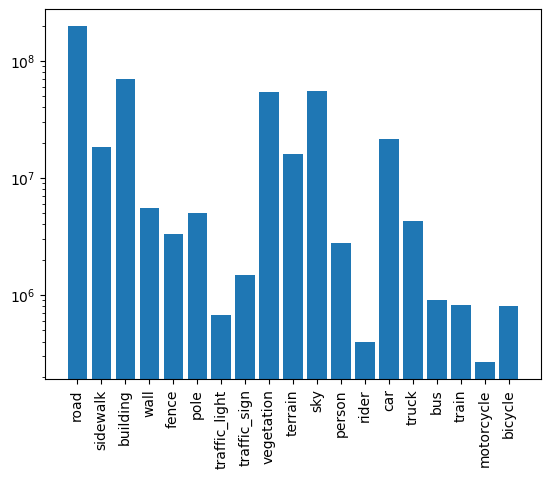

In [16]:
classes = np.array(("road", "sidewalk",
    "building", "wall", "fence", "pole",
    "traffic_light", "traffic_sign", "vegetation",
    "terrain", "sky", "person", "rider",
    "car", "truck", "bus",
    "train", "motorcycle", "bicycle"))


a = plt.bar(x=classes,height=class_count, log=True)
a = plt.xticks(rotation="vertical")
plt.savefig(os.path.join(viz_dir, "dacs_mixed_distr"))

In [17]:
mixed_distr_dir = "/home/gpss1/remote/phd/code/dacs_fork/data/data_visualization/mixed_distr/"
for val in range(num_classes):
    road_count_img = road_count_img_list[val]
    road_distr = 255 * road_count_img / np.max(road_count_img)
    road_distr = np.repeat(road_distr.reshape((*road_distr.shape, 1)), 3, axis=2)
    road_distr = PIL.Image.fromarray(road_distr.astype(np.uint8))
    road_distr.save(os.path.join(mixed_distr_dir, "{}.png".format(classes[val])))